In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


data=pd.read_csv('/Users/Manish/Desktop/Datasets/training_variants')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
data_text=pd.read_csv('/Users/Manish/Desktop/Datasets/training_text', sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [4]:
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
stop_words=set(stopwords.words('english'))

def preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        #replacing special characters with space
        total_text=re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        #replacing multiple spaces with single space
        total_text=re.sub('\s+',' ',total_text)
        #making all char to lowercase 
        total_text=total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string+=word + " "
        
        data_text[column][index]=string
    
    

In [6]:
start_time=time.clock()
for index,row in data_text.iterrows():
    if type(row['TEXT']) is str:
        preprocessing(row['TEXT'],index,'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")
        
        

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 172.4356037 seconds


In [7]:
for index,row in data_text.head(5).iterrows():
    print(index,row)

0 ID                                                      0
TEXT    cyclin dependent kinases cdks regulate variety...
Name: 0, dtype: object
1 ID                                                      1
TEXT    abstract background non small cell lung cancer...
Name: 1, dtype: object
2 ID                                                      2
TEXT    abstract background non small cell lung cancer...
Name: 2, dtype: object
3 ID                                                      3
TEXT    recent evidence demonstrated acquired uniparen...
Name: 3, dtype: object
4 ID                                                      4
TEXT    oncogenic mutations monomeric casitas b lineag...
Name: 4, dtype: object


In [8]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [11]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [12]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [14]:
train_class_distribution=train_df['Class'].value_counts().sortlevel()
test_class_distribution=test_df['Class'].value_counts().sortlevel()
cv_class_distribution=cv_df['Class'].value_counts().sortlevel()

Number of data points in class 7 : 609
Number of data points in class 4 : 439
Number of data points in class 1 : 363
Number of data points in class 2 : 289
Number of data points in class 6 : 176
Number of data points in class 5 : 155
Number of data points in class 3 : 57
Number of data points in class 9 : 24
Number of data points in class 8 : 12


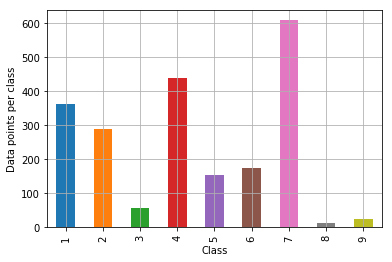

In [15]:
my_colors='rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.grid()
plt.show

sorted_yi=np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class",i+1,':',train_class_distribution.values[i])

--------------------------------------------------------------------------------
Number of data points in class 7 : 191
Number of data points in class 4 : 137
Number of data points in class 1 : 114
Number of data points in class 2 : 91
Number of data points in class 6 : 55
Number of data points in class 5 : 48
Number of data points in class 3 : 18
Number of data points in class 9 : 7
Number of data points in class 8 : 4


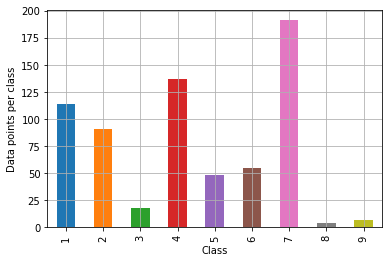

In [16]:
print('-'*80)
my_colors='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.grid()
plt.show

sorted_yi=np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class",i+1,':',test_class_distribution.values[i])


--------------------------------------------------------------------------------
Number of data points in class 7 : 153
Number of data points in class 4 : 110
Number of data points in class 1 : 91
Number of data points in class 2 : 72
Number of data points in class 6 : 44
Number of data points in class 5 : 39
Number of data points in class 3 : 14
Number of data points in class 9 : 6
Number of data points in class 8 : 3


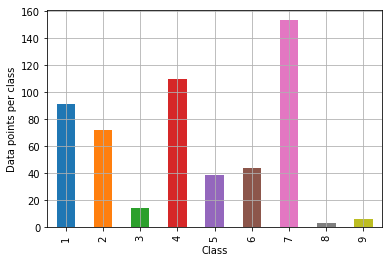

In [17]:
print('-'*80)
my_colors='rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.grid()
plt.show

for i in sorted_yi:
    print("Number of data points in class",i+1,':',cv_class_distribution.values[i])


In [18]:
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B = (C/C.sum(axis=0))
    
    labels=[1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted labels')
    plt.ylabel('orginal labels')
    plt.show()
    
    print("-"*20, "Precision Matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted labels')
    plt.ylabel('orginal labels')
    plt.show()
    
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted labels')
    plt.ylabel('orginal labels')
    plt.show()
    
    

Log loss on Cross Validation Data using Random Model 2.507946765444619
Log loss on Test Data using Random Model 2.5030241980876995
-------------------- Confusion matrix --------------------


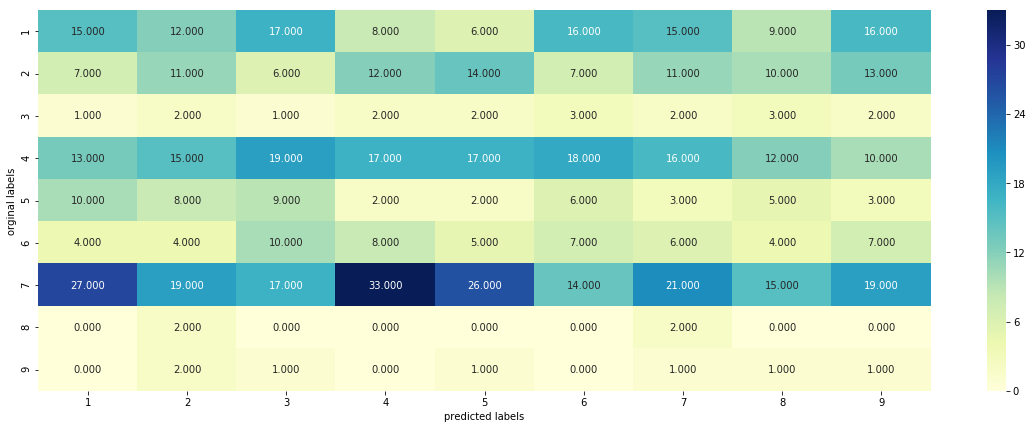

-------------------- Precision Matrix --------------------


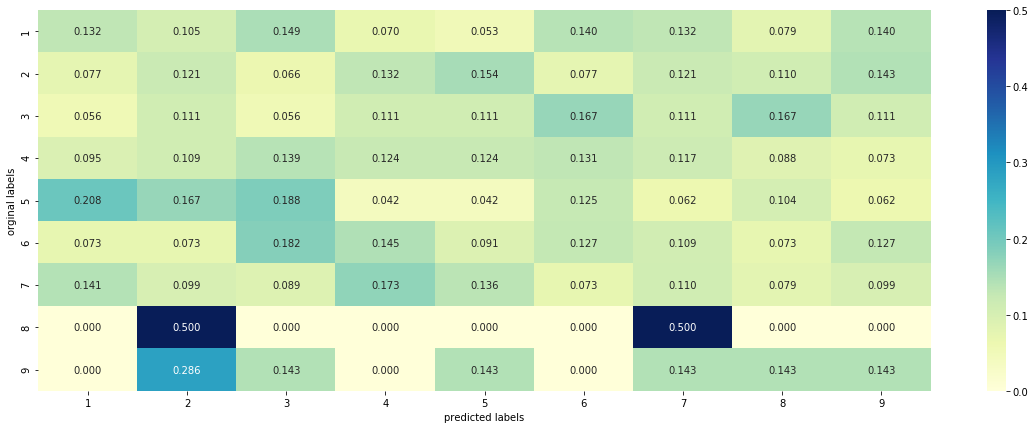

-------------------- Recall matrix --------------------


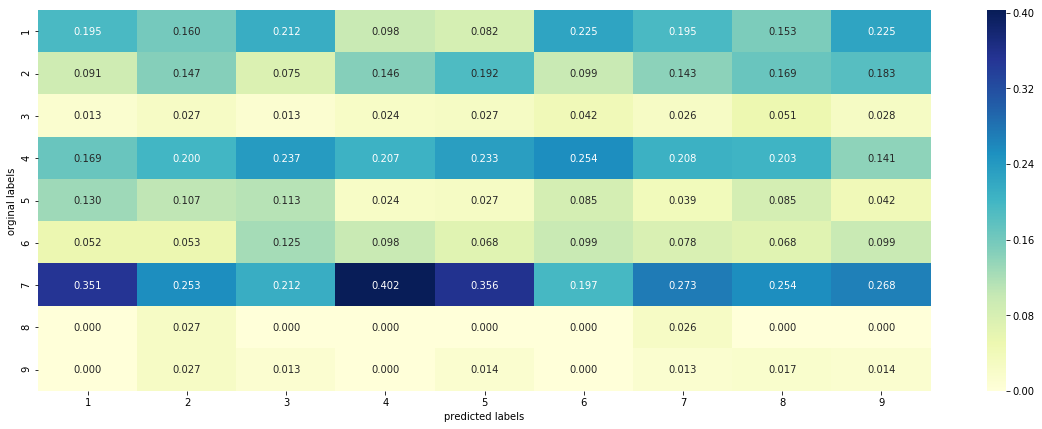

In [19]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [20]:
unique_genes=train_df['Gene'].value_counts()
print("Number of unique genes: ",unique_genes.shape[0])
unique_genes.head(10)


Number of unique genes:  234


BRCA1     179
TP53      109
EGFR       94
PTEN       87
BRCA2      74
BRAF       68
KIT        60
ALK        48
ERBB2      40
PDGFRA     34
Name: Gene, dtype: int64

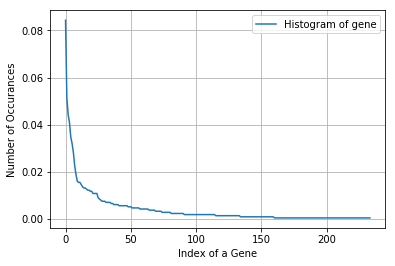

In [21]:
s=sum(unique_genes.values)
h=unique_genes.values/s

plt.plot(h,label='Histogram of gene')
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

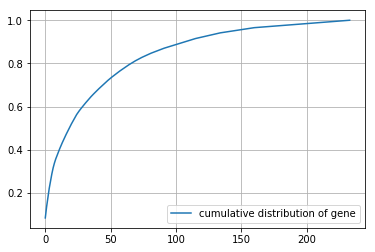

In [22]:
c=np.cumsum(h)
plt.plot(c,label='cumulative distribution of gene')
plt.grid()
plt.legend()
plt.show()


In [23]:
train_df['Gene'].head()

687     CDKN2A
1588       VHL
618      FBXW7
2149      PTEN
260       EGFR
Name: Gene, dtype: object

In [30]:
alpha=1
train_gene_feature_responseCoding=np.array(get_gv_feature(alpha,'Gene',train_df))
test_gene_feature_responseCoding=np.array(get_gv_feature(alpha,'Gene',test_df))
cv_gene_feature_responseCoding=np.array(get_gv_feature(alpha,'Gene',cv_df))

In [31]:

def get_gv_fea_dict(alpha, feature, df):
   
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        
   
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [32]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [33]:
gene_vectorizer=CountVectorizer()
train_gene_feature_onehotCoding=gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding=gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [34]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 234)


For values of alpha =  1e-05 The log loss is: 1.454365741806178
For values of alpha =  0.0001 The log loss is: 1.2738906221909292
For values of alpha =  0.001 The log loss is: 1.278849340129322
For values of alpha =  0.01 The log loss is: 1.3935302340422175
For values of alpha =  0.1 The log loss is: 1.4684409861828336
For values of alpha =  1 The log loss is: 1.5025394775177376


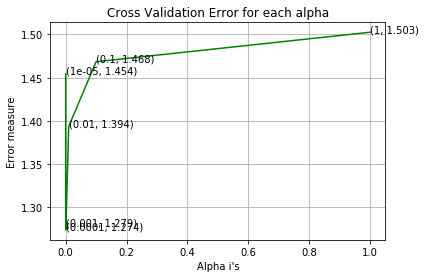

For values of best alpha =  0.0001 The train log loss is: 1.055048471653584
For values of best alpha =  0.0001 The cross validation log loss is: 1.2738906221909292
For values of best alpha =  0.0001 The test log loss is: 1.192085925187958


In [35]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [36]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  234  genes in train dataset?
Ans
1. In test data 641 out of 665 : 96.39097744360903
2. In cross validation data 521 out of  532 : 97.93233082706767


In [37]:
unique_variations =train_df['Variation'].value_counts()
print("Number of unique variations: ",unique_variations.shape[0])
unique_variations.head(10)

Number of unique variations:  1927


Truncating_Mutations    58
Deletion                55
Amplification           45
Fusions                 21
Overexpression           4
G12V                     3
T58I                     3
G13D                     2
F28L                     2
F384L                    2
Name: Variation, dtype: int64

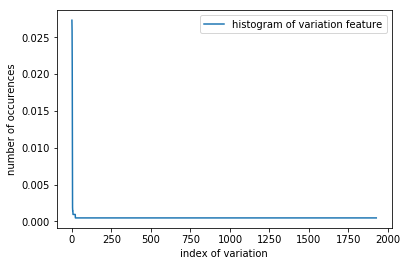

In [38]:
s=sum(unique_variations.values)
h=(unique_variations.values)/s
plt.plot(h,label='histogram of variation feature')
plt.xlabel('index of variation')
plt.ylabel('number of occurences')
plt.legend()
plt.show()

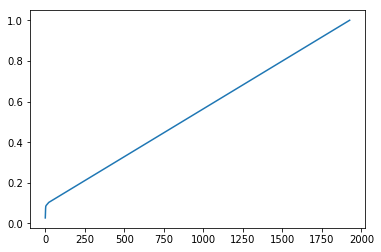

In [39]:
c=np.cumsum(h)
plt.plot(c)

In [40]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))


In [49]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [50]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [51]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1958)


For values of alpha =  1e-05 The log loss is: 1.7259290169248562
For values of alpha =  0.0001 The log loss is: 1.7099233015974167
For values of alpha =  0.001 The log loss is: 1.709379399584793
For values of alpha =  0.01 The log loss is: 1.7155858354373372
For values of alpha =  0.1 The log loss is: 1.725556104040435
For values of alpha =  1 The log loss is: 1.7269139916099945


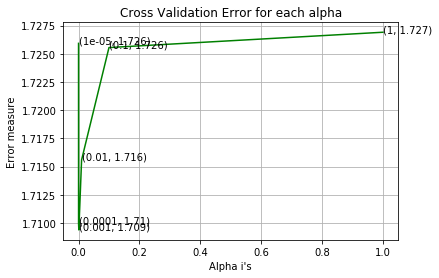

For values of best alpha =  0.001 The train log loss is: 1.064748892563846
For values of best alpha =  0.001 The cross validation log loss is: 1.709379399584793
For values of best alpha =  0.001 The test log loss is: 1.7163680405683375


In [52]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [53]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print("The no of points covered",test_coverage,"out of",test_df.shape[0],":",(test_coverage/test_df.shape[0])*100)
print("The no of points covered",cv_coverage,"out of",cv_df.shape[0],":",(cv_coverage/cv_df.shape[0])*100)

The no of points covered 69 out of 665 : 10.37593984962406
The no of points covered 49 out of 532 : 9.210526315789473


In [54]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [55]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [56]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53363


In [57]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [58]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [59]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [60]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

For values of alpha =  1e-05 The log loss is: 1.34574284754322
For values of alpha =  0.0001 The log loss is: 1.3130915770203448
For values of alpha =  0.001 The log loss is: 1.1976122112476544
For values of alpha =  0.01 The log loss is: 1.3263611682476726
For values of alpha =  0.1 The log loss is: 1.449267492598901
For values of alpha =  1 The log loss is: 1.647654848742646


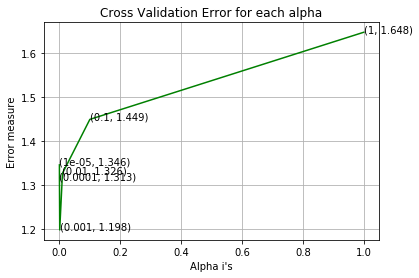

For values of best alpha =  0.001 The train log loss is: 0.7962350716981693
For values of best alpha =  0.001 The cross validation log loss is: 1.1976122112476544
For values of best alpha =  0.001 The test log loss is: 1.1221216654120822


In [61]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [62]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [63]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.473 % of word of test data appeared in train data
97.39 % of word of Cross Validation appeared in train data
